In [215]:
import os
import cv2 as cv
import numpy as np
from skimage.io import imshow

from inspection.support.utils import cut, align, extract_with_mask, highlight, inpaint, highpass

# Setup


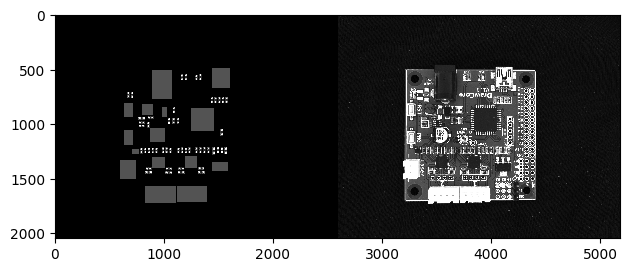

In [414]:
source_folder = (
    "/media/egor/T7/vut_dp_project_workspace/assets/datasets/custom_structured"
)
targets = [
    "24_drawcore_um_16mm_f8_4580",
    "25_drawcore_um_16mm_f8_3110",
    "26_drawcore_um_16mm_f8_5236",
]

# Image to perform inspection against
template_original = cv.cvtColor(
    cv.imread("inspection/support/um_camera/drawcore.bmp"),
    cv.COLOR_BGR2GRAY,
)
# Image with components covered
template_cover = cv.cvtColor(
    cv.imread("inspection/support/covers/drawcore_2.png"),
    cv.COLOR_BGR2GRAY,
)
template_cover_original = cv.cvtColor(
    cv.imread("inspection/support/um_camera/drawcore.bmp"),
    cv.COLOR_BGR2GRAY,
)
imshow(np.hstack([template_cover, template_cover_original]))

# Remove background

Remove background from template image once and use coordinates to remove background from tested images after alignment.


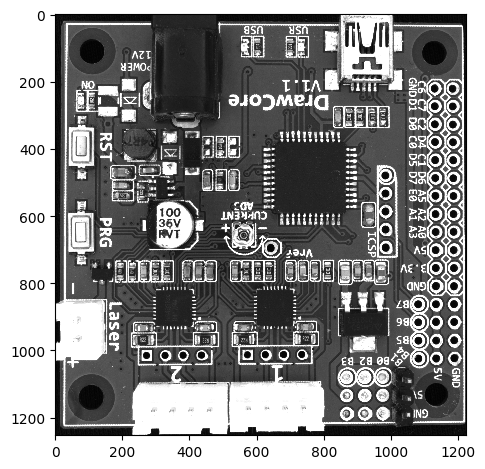

In [354]:
im = template_original
im = align(im, template_cover_original)

# Blur to vanish texture defects
im = cv.medianBlur(im, 55)

# Arbitrary selected global threshold to separate background
val, im = cv.threshold(im, 40, 255, cv.THRESH_BINARY)

analysis = cv.connectedComponentsWithStats(im, cv.CV_32S)
(_, _, values, _) = analysis

# Select the biggest connected component (PCB desk)
mx, mxi = 0, 0
for i, value in enumerate(values):
    area = value[cv.CC_STAT_AREA]
    if area >= mx:
        mxi = i

REMOVE_BACKGROUND_VALUE = values[mxi]
im = cut(align(template_original, template_cover_original),
         REMOVE_BACKGROUND_VALUE)

imshow(im)

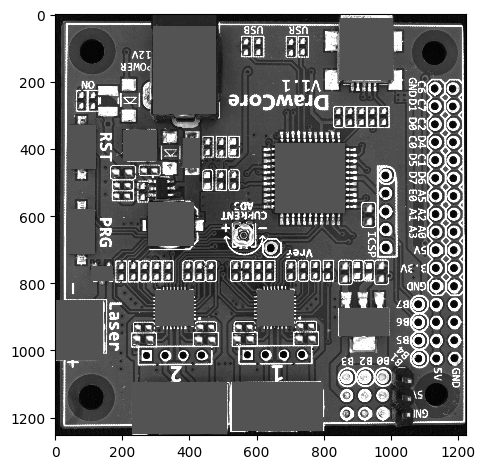

In [416]:
template_cover_reduced = cut(template_cover, REMOVE_BACKGROUND_VALUE)
template_original_reduced = cut(
    align(template_original, template_cover_original), REMOVE_BACKGROUND_VALUE
)

erase_cover = template_cover_reduced.copy()
erase_cover[erase_cover > 0] = 1
erase_cover = 1 - erase_cover

template_original_reduced = np.multiply(template_original_reduced, erase_cover)
template_original_covered = template_original_reduced + template_cover_reduced

imshow(template_original_covered)

# Mask transfer and control area selection

Select all masked components for accuracy tests. Store components them self (chunks), coordinates in tested image and label of chunk.


In [428]:
all_images = []  # [im1, im2, ...]
all_values = []  # [[val1, val2, ...], ...]

template_cover_reduced = template_cover.copy()
template_cover_reduced = cut(template_cover_reduced, REMOVE_BACKGROUND_VALUE)
template_cover_reduced[template_cover_reduced > 0] = 255

for target in targets:
    # Walk different camera setups
    print(f"Processing: {target}")
    for f in os.listdir(f"{source_folder}/{target}"):
        # Load each image to perform inspection on
        tested_image = cv.imread(f"{source_folder}/{target}/{f}")
        # Perform component location extraction
        im = cv.cvtColor(
            align(tested_image, template_cover_original), cv.COLOR_RGB2GRAY
        )
        im = cut(im, REMOVE_BACKGROUND_VALUE)
        all_images.append(im)

        _, values = extract_with_mask(im, template_cover_reduced)
        all_values.append(values)

Processing: 24_drawcore_um_16mm_f8_4580
Processing: 25_drawcore_um_16mm_f8_3110
Processing: 26_drawcore_um_16mm_f8_5236


# Component detection


## DWT


In [386]:
def iter_average_h(im: np.ndarray):
    # Eq. 3
    r, c = im.shape[0], im.shape[1]

    res = np.zeros((r, int(np.floor(c / 2))))
    for i in range(int(np.floor(c / 2))):
        res[:, i] = (im[:, 2 * i - 1] + im[:, 2 * i]) / 2

    return res


def iter_difference_h(im: np.ndarray):
    # Eq. 4. It seems that there is an error in indexes (I assume that logic is the same as in eq. 6-9).
    r, c = im.shape[0], im.shape[1]

    res = np.zeros((r, int(np.floor(c / 2))))
    for i in range(int(np.floor(c / 2))):
        res[:, i] = (im[:, 2 * i] - im[:, 2 * i - 1]) / 2

    return res


def iter_average_v(im: np.ndarray):
    # Eq. 6, 7
    r, c = im.shape[0], im.shape[1]

    res = np.zeros((int(np.floor(r / 2)), c))
    for i in range(int(np.floor(r / 2))):
        res[i, :] = (im[2 * i - 1, :] + im[2 * i, :]) / 2

    return res


def iter_difference_v(im: np.ndarray):
    # Eq. 8, 9
    r, c = im.shape[0], im.shape[1]

    res = np.zeros((int(np.floor(r / 2)), c))
    for i in range(int(np.floor(r / 2))):
        res[i, :] = (im[2 * i, :] - im[2 * i - 1, :]) / 2

    return res


def dwt(im: np.ndarray, n=1):
    for i in range(n):
        s = iter_average_h(im)

        d = iter_difference_h(im)

        ul = iter_average_v(s)
        ur = iter_average_v(d)
        ll = iter_difference_v(s)
        lr = iter_difference_v(d)

        im = ul

    return ul, ur, ll, lr


def is_component_present(
    test_im: np.ndarray,
    template_im: np.ndarray,
    dwt_iter=3,
    binarization_threshold=10,
    allowed_difference_percent=0.05,
    blur_kernel_size=0,
):
    if blur_kernel_size:
        test_im = cv.medianBlur(test_im, blur_kernel_size)
        template_im = cv.medianBlur(template_im, blur_kernel_size)

    test_dwt, _, _, _ = dwt(test_im, n=dwt_iter)
    template_dwt, _, _, _ = dwt(template_im, n=dwt_iter)

    diff = np.abs(template_dwt - test_dwt)
    diff_bin = diff > binarization_threshold

    test = (diff_bin.sum() / diff_bin.size) < allowed_difference_percent

    return [test, diff]

### Test case generation


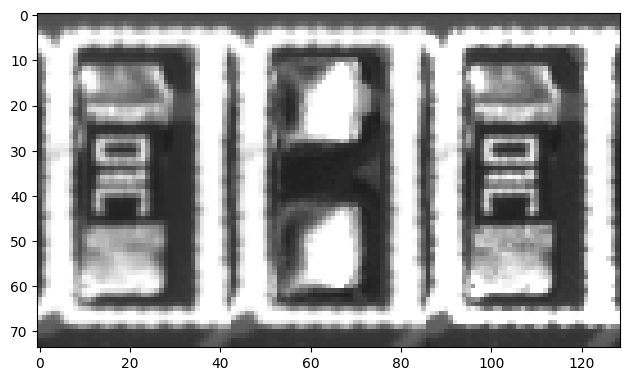

In [434]:
image_index = 2
chunk_index = 10

test_image = all_images[image_index]
test_values = all_values[image_index]

template_image = template_original
template_image = align(template_image, template_cover_original)
template_image = cut(template_image, REMOVE_BACKGROUND_VALUE)

template_cover_reduced = template_cover
template_cover_reduced = cut(template_cover_reduced, REMOVE_BACKGROUND_VALUE)

value = test_values[chunk_index]
test_image_inp = inpaint(template_cover_reduced, test_image, value)

value = value.copy()
value[0] = value[0] - 10
value[1] = value[1] - 10
value[2] = value[2] + 20
value[3] = value[3] + 20

test_chunk = cut(test_image, value)
test_chunk_inp = cut(test_image_inp, value)
template_chunk = cut(template_image, value)

# imshow(np.hstack([test_image_inp, test_image, template_image]))
imshow(np.hstack([test_chunk, test_chunk_inp, template_chunk]))

Bare test image: present
Inpainted test image: missing


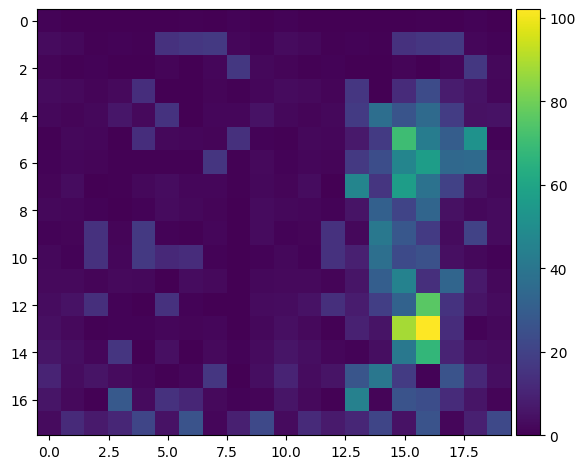

In [420]:
threshold = 30
allow = 0.05

test, diff = is_component_present(
    test_chunk,
    template_chunk,
    dwt_iter=2,
    binarization_threshold=threshold,
    allowed_difference_percent=allow,
)
test_inp, diff_inp = is_component_present(
    test_chunk_inp,
    template_chunk,
    dwt_iter=2,
    binarization_threshold=threshold,
    allowed_difference_percent=allow,
)
print(f'Bare test image: {"present" if test else "missing"}')
print(f'Inpainted test image: {"present" if test_inp else "missing"}')
imshow(np.hstack([diff, diff_inp]))
# imshow(np.hstack([diff > threshold, diff_inp > threshold]))

### Inspection quality evaluation


In [429]:
template_image = template_original
template_image = align(template_image, template_cover_original)
template_image = cut(template_image, REMOVE_BACKGROUND_VALUE)

template_cover_reduced = template_cover
template_cover_reduced = cut(template_cover_reduced, REMOVE_BACKGROUND_VALUE)

all_inspections = []
for test_image, test_values in zip(all_images, all_values):
    for test_value in test_values:
        test_image_inp = inpaint(template_cover_reduced, test_image, test_value)

        value = test_value.copy()
        value[0] = value[0] - np.random.randint(8, 12)
        value[1] = value[1] - np.random.randint(8, 12)
        value[2] = value[2] + np.random.randint(18, 22)
        value[3] = value[3] + np.random.randint(18, 22)

        test_chunk = cut(test_image, value)
        test_chunk_inp = cut(test_image_inp, value)
        template_chunk = cut(template_image, value)

        inspection = is_component_present(
            test_chunk_inp,
            template_chunk,
            dwt_iter=2,
            binarization_threshold=threshold,
            allowed_difference_percent=allow,
        )
        all_inspections.append(
            [*inspection, test_chunk, test_chunk_inp, template_chunk]
        )

/tmp/ipykernel_171061/1420158995.py:79: RuntimeWarning: invalid value encountered in scalar divide
  test = (diff_bin.sum() / diff_bin.size) < allowed_difference_percent


In [430]:
failed = []
for inspection in all_inspections:
    if inspection[0]:
        failed.append(inspection)
print(len(failed))

0


In [ ]:
test, diff, test_chunk, test_chunk_inp, template_chunk = failed[0]
imshow(np.hstack([test_chunk, test_chunk_inp]))